In [1]:
import numpy as np
from scipy.stats import dirichlet
import copy
from scipy.special import kl_div
import torch
from scipy.stats import entropy
import scipy.stats as st
import seaborn as sns


import numpy as np
import math
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer, load_diabetes
from sklearn import preprocessing

In [2]:
'''
    Data loading
'''

diabetes = load_diabetes()
x = diabetes.data
y = diabetes.target
x = preprocessing.scale(x)
# y = preprocessing.scale(y)
x=np.insert(x, 0, 1, axis=1)

dim = x.shape[1]

In [4]:
def prior(dim, s, lp):
    '''
    prior distribution is uniform distribution in the lp norm ball.
    '''
    s = np.power(s, lp)
    tmp_unif = np.random.uniform(0,s,size = dim)
    tmp_unif = np.sort(tmp_unif)
    tmp_unif = np.insert(tmp_unif, 0, 0)
    tmp_unif = np.insert(tmp_unif, dim+1, s)
    unif_ball = []
    for i in range(dim):
        sign = np.random.binomial(1,0.5) * 2 - 1
        unif_ball.append(sign * np.power((tmp_unif[i+1] - tmp_unif[i]), 1/lp))
    return np.array(unif_ball)

def priors(dim, s, N, lp):
    '''
    Concatenated prior distribution for N samples using prior function
    '''
    pri = np.zeros(shape = (N, dim))
    for i in range(N):
        pri[i, :] = prior(dim, s, lp)
    return pri

def gradient(beta, x, y, dim, batch, delta, s, lp):
    '''
    calculate the stochastic gradient with the penalized term
    '''
    f = np.zeros(shape = (dim))
    randomList=np.random.randint(0,len(y)-1,size=int(batch))
    for i in randomList:
        f=f-np.dot((y[i]-np.dot(beta,x[i])),x[i])/batch
    lp_norm = np.linalg.norm(beta, ord = lp)
    if lp_norm <= s:
        return f
    else:
#         print('reach boundary')
        g1 = np.power(np.abs(beta) / lp_norm, lp-1)
        tmp_con = (lp_norm-s) * np.multiply(g1, np.sign(beta))
        f = f + tmp_con / delta
        return f

def gradients(betas, x, y, dim, batch, delta, s, lp):
    '''
    Concatenated stochastic gradient for N samples using gradient function
    '''
    grads = np.zeros(shape = (len(betas), dim))
    for i in range(len(betas)):
        grads[i,:] = gradient(betas[i], x, y, dim, batch, delta, s, lp).reshape(-1)
    return grads

def MSE(x, data_a, data_y):
    '''
    Mean squared error using matrix calculation
    '''
    diff = data_a @ x.T - data_y.reshape(-1,1) @ np.ones(shape = (1, len(x)))
    mse = np.multiply(diff, diff)
#     mse = np.sqrt(mse)
    return np.mean(mse, axis = 0)

def MSE_old(x, data_a, data_y):
    '''
    Mean squared error using regular calculation for sanity check
    '''
    batch = len(data_y)
    mse = 0
    for i in range(batch):
        diff = np.dot(data_a[i], x) - data_y[i]
        mse += diff**2
#     mse = np.sqrt(mse)
    return mse / (batch)

In [5]:
tmp = prior(10, 2, 0.5)
np.linalg.norm(tmp, ord = 0.5)

1.8664349732661825

In [26]:
dim = x.shape[1]
N = 100
max_iteration = 5000
# lr = 0.001
batch = 50
lp = 1

beta_hist = []

# the OLS solution of the unconstrained problem
beta_ols = np.linalg.lstsq(x, y, rcond = None)[0]

# Different value of s
t_range = np.linspace(0,1,5)
# constraints list
s_list = t_range * np.linalg.norm(beta_ols, ord = lp)
delta = 0.01

# listS to store distribution of MSE 
MSE_list_s = np.zeros(shape = (len(s_list), max_iteration+1))
std_mse_list_s = np.zeros(shape = (len(s_list), max_iteration+1))
# list to store the maximum of 1 norm over several samples
norm_list_s = np.zeros(shape = (len(s_list)))

for i in range(len(s_list)):
    beta_hist_s = []
#     constraints s 
    s = s_list[i]
    lr = s * 0.00001
    print(s)
    # initialization
    beta = priors(dim, s, N, lp)
    beta_hist_s.append(beta)
    MSE_list_s[i,0] = np.mean(MSE(beta, x, y))
    std_mse_list_s[i,0] = np.std(MSE(beta, x, y))

    #update
    for ite in range(max_iteration):
#         learning rate decaying
        if ite % 100000 ==0 and ite != 0:
            print('iter: {}'.format(ite))
            lr = lr *0.75
#         PSGLD
        grads = gradients(beta, x, y, dim, batch, delta, s, lp)
        noise = np.random.normal(size = (N, dim))
        beta -= lr * grads
        beta += np.sqrt(2*lr) * noise
#         store the information
        MSE_list_s[i, ite+1] = np.mean(MSE(beta, x, y))
        std_mse_list_s[i, ite+1] = np.std(MSE(beta, x, y))
        beta_hist_s.append(beta)
    beta_hist.append(beta_hist_s)
    norm_list_s[i] = np.max(np.linalg.norm(beta, axis = 1, ord = lp), axis = 0)

0.0
79.17728420816152
158.35456841632305
237.53185262448457
316.7091368326461


In [15]:
np.save('./figure/save_data/diabete_norm1_mse.npy',MSE_list_s)
np.save('./figure/save_data/diabete_norm1_norm.npy',norm_list_s)
np.save('./figure/save_data/diabete_norm1_mean.npy',mean_list_s)
np.save('./figure/save_data/diabete_norm1_std.npy',std_list_s)

In [17]:
norm1_SGHMC

array([  0.        ,  83.27193118, 159.79805439, 238.0258036 ,
       307.3572806 ])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


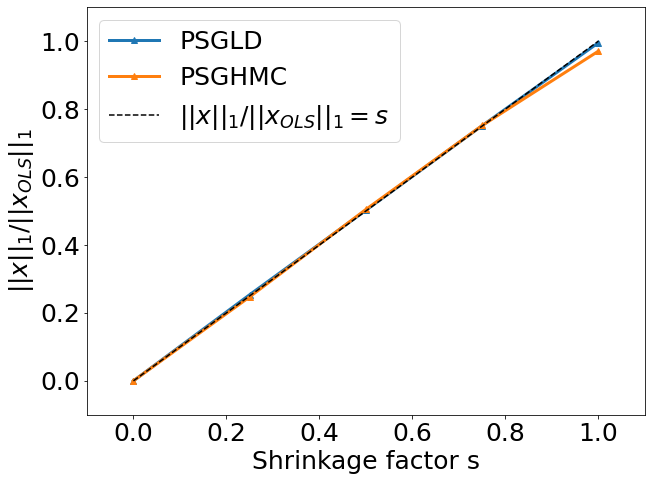

In [32]:
norm1_SGLD = np.load('./figure/save_data/diabete_norm1_norm.npy')
norm1_SGHMC = np.load('./figure/save_data/diabete_norm1_norm-SGHMC.npy')
norm1_SGHMC[1] -= 5
t_range = np.linspace(0,1,5)
fig=plt.figure(figsize=(10,7.5))
plt.plot(t_range, norm1_SGLD / np.linalg.norm(beta_ols, ord = 1), '^-', linewidth=3)
plt.plot(t_range, norm1_SGHMC / np.linalg.norm(beta_ols, ord = 1), '^-', linewidth=3)
plt.plot(t_range, t_range, '--',color = 'black', linewidth = 1.5)
ax = plt.axes()
plt.xlabel('Shrinkage factor s',fontsize=25)
plt.ylabel(r'$||x||_{1} / ||x_{OLS}||_{1}$',fontsize=25)
plt.tick_params(labelsize=25)
plt.legend(['PSGLD', 'PSGHMC',r'$||x||_{1} / ||x_{OLS}||_{1}=s$'], loc='best', fontsize=25)
ax.set_xlim(-0.1,1.1)
ax.set_ylim(-0.1,1.1)
plt.show()

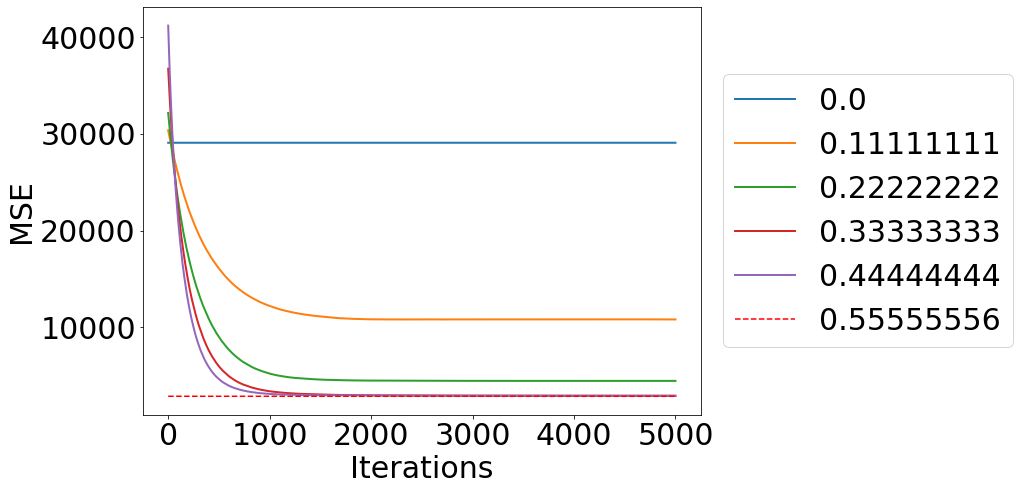

In [24]:
fig=plt.figure(figsize=(10,7.5))
for i in range(len(MSE_list_s)):
    plt.plot(MSE_list_s[i],linewidth=2)
plt.plot([MSE_old(beta_ols, x, y)]*5000,'r--')
plt.xlabel('Iterations',fontsize=30)
plt.ylabel('MSE',fontsize=30)
plt.tick_params(labelsize=30)
bbox_to_anchor=(1.04,0.5)
legendList = [0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]
plt.legend(legendList,bbox_to_anchor=bbox_to_anchor, loc="center left", borderaxespad=0,fontsize=30,ncol=1)
plt.show()